In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.decomposition import PCA

# 1. 피클 파일에서 Series 불러오기
with open('data/okt.pkl', 'rb') as f:
    normalized = pickle.load(f)
    
    #불용어 읽어오기
stopwords_file_path = 'stopwords_dh_last.txt'
stopwords = []
with open(stopwords_file_path, 'r', encoding='utf-8') as file:
    stopwords = [line.strip() for line in file.readlines()]

# 2. TF-IDF 벡터라이저 설정: 상위 10,000개의 단어만 사용하고 불용어 제거
vectorizer = TfidfVectorizer(max_features=10000, stop_words=stopwords, min_df=2, max_df=0.95)

# 3. 데이터프레임을 1000개씩 나눠서 처리할 준비
chunk_size = 1000
tfidf_result = []  # 청크 처리 결과를 저장할 리스트

print("처리 시작...")

# 4. 데이터를 청크로 나누어 처리
for i in range(0, len(normalized), chunk_size):
    # 현재 청크 데이터 추출
    doc_chunk = normalized[i:i+chunk_size]
    
    # TF-IDF 적용
    tfidf_array = vectorizer.fit_transform(doc_chunk)
    
    # 청크 결과를 데이터프레임으로 변환하여 리스트에 저장
    tfidf_result.append(pd.DataFrame(tfidf_array.toarray(), columns=vectorizer.get_feature_names_out()))
    
    # 청크 처리 완료 메시지 출력
    print(f"{i+chunk_size}개 문서 처리 완료")

# 5. 모든 청크를 하나의 데이터프레임으로 합침
tfidf_df = pd.concat(tfidf_result, ignore_index=True)

# 불용어 제거 및 LDA 적용
def remove_stopwords(text):
    tokens = text.split()  # 공백으로 나누기
    filtered_tokens = [word for word in tokens if word not in stopwords]  # 불용어 제거
    return ' '.join(filtered_tokens)  # 다시 문자열로 결합

normalized_cleaned = [remove_stopwords(' '.join([word for word in text.split() if word not in stopwords])
) for text in normalized]

# TF-IDF 벡터라이저 적용
vectorizer = TfidfVectorizer(max_features=10000)
tfidf_matrix = vectorizer.fit_transform(normalized_cleaned)



처리 시작...


c:\Users\user\anaconda3\envs\myenv\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['겸박월금의소송수계인', '경락인', '고지명령청구자', '공동소송적', '국선', '군검찰관', '낙찰인', '낙찰자', '당심', '독립참가', '매수인', '미성년자', '반심판피청구인', '반심피청구인', '법정대리인', '변론관여', '본심판상대방', '본안원고', '비약', '비약적', '사선', '소외1소송수계인', '수계신청인', '신청인겸파산자', '예비적', '위반자', '유언자', '유언집행자', '이의피신청인', '자녀', '재심상대방', '재심판청구인', '재심피청구인', '제3공탁자', '주1', '주위적', '중간확인피고', '탈퇴', '피공개', '피이의신청인'] not in stop_words.
  warnings.warn(


1000개 문서 처리 완료
2000개 문서 처리 완료
3000개 문서 처리 완료
4000개 문서 처리 완료
5000개 문서 처리 완료


In [31]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np

pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())
components=pca.components_.T

# 한글 폰트 설정 (Windows에서의 Malgun Gothic)
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 폰트 경로 설정
font_prop = font_manager.FontProperties(fname=font_path)


def biplot(score, coeff, labels=None, threshold=0.0):
    """
    PCA 결과의 biplot을 그립니다.

    score: 차원 축소된 데이터, (n_samples, 2) 모양의 배열이어야 함
    coeff: 원래 특성 공간의 주성분 벡터, (n_features, 2) 모양의 배열이어야 함
    labels: 특성의 이름 목록, 기본값은 None
    """
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]

    plt.figure(figsize=(10, 6))
    plt.scatter(xs, ys, alpha=0.5, color='darkcyan')

    # 각 주성분에 대한 화살표 그리기
    for i in range(n):
        if np.linalg.norm(coeff[i]) >= threshold:
            plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='darkgreen', alpha=0.5)
            if labels is None:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='darkblue', ha='center', va='center',fontproperties=font_prop)
            else:
                plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='darkblue', ha='center', va='center',fontproperties=font_prop)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()
    plt.title("PCA Biplot")
    plt.show()


# Biplot 그리기
feature_names = vectorizer.get_feature_names_out()  # TF-IDF에서 사용된 특성 이름
# biplot(pca_result, components, labels=feature_names)

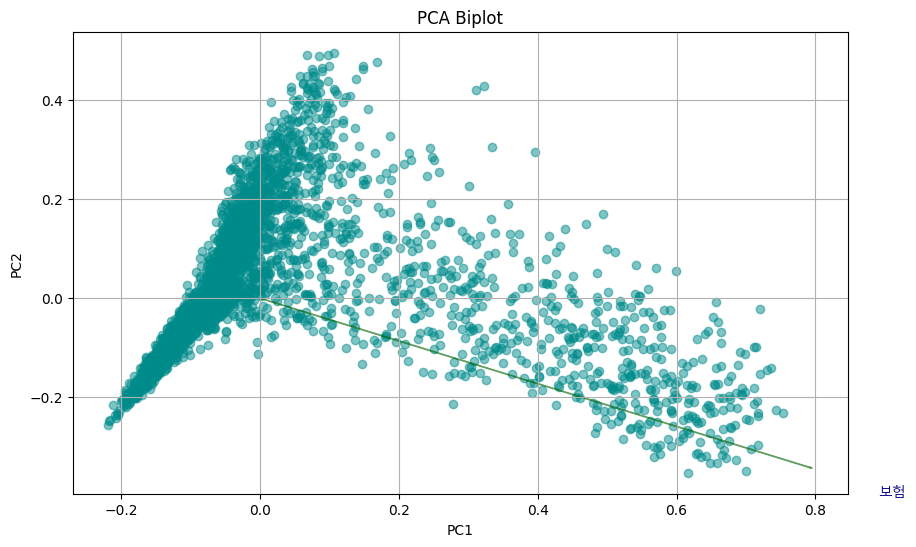

In [43]:
biplot(pca_result, components, labels=feature_names,threshold=0.7)

# 시도 

70% 이상 변동성을 설명하는 주성분: []


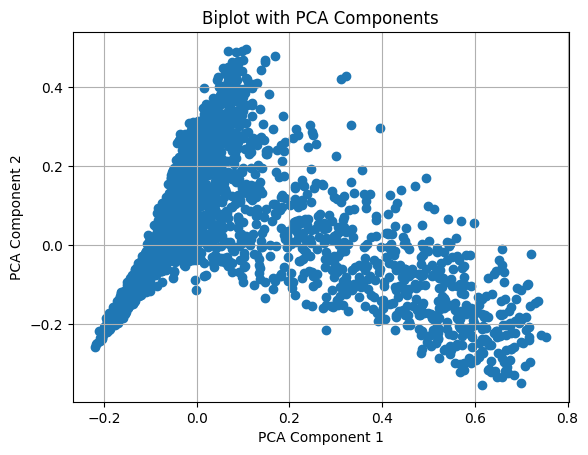

In [36]:
from sklearn.preprocessing import Normalizer

# 5. TF-IDF 행렬 정규화
normalizer = Normalizer()
tfidf_normalized = normalizer.fit_transform(tfidf_matrix)


# PCA 수행
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_normalized.toarray())
# 누적 변동성 계산
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# 누적 변동성이 70% 이상 되는 주성분 선택
selected_components = np.where(cumulative_variance >= 0.7)[0] + 1
print(f"70% 이상 변동성을 설명하는 주성분: {selected_components}")

# biplot 시각화
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('Biplot with PCA Components')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

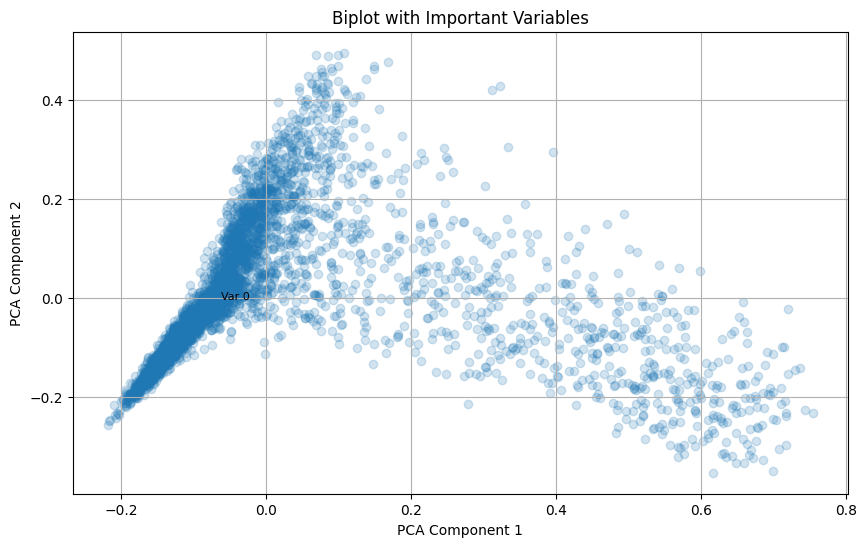

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

# TF-IDF 행렬 정규화
# normalizer = Normalizer()
# tfidf_normalized = normalizer.fit_transform(tfidf_matrix)

# PCA 수행
pca = PCA(n_components=2)
pca_result = pca.fit_transform(tfidf_matrix.toarray())

# PCA 수행 후, PCA 컴포넌트와 원본 변수 간의 상관계수 계산
correlation_matrix = np.corrcoef(pca_result.T)
correlation_threshold = 0.5

# 상관계수 절대값이 threshold보다 큰 변수 인덱스 추출
important_indices = np.where(np.abs(correlation_matrix[0]) > correlation_threshold)[0]

# 상위 N개 변수 선택
top_n = 10  # 원하는 상위 N개 수
sorted_indices = np.argsort(-np.abs(correlation_matrix[0, important_indices]))[:top_n]

# 시각화
plt.figure(figsize=(10, 6))
for i in sorted_indices:
    plt.text(pca_result[important_indices[i], 0], 
             pca_result[important_indices[i], 1], 
             f'Var {important_indices[i]}', 
             fontsize=8)
    
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.2)  # 전체 데이터 포인트
plt.title('Biplot with Important Variables')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()